# Imports

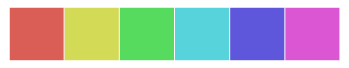

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pd.set_option('display.max_rows', 50)
palette = sns.color_palette("hls")
sns.palplot(palette)
sns.set_palette(palette)
## plot config
gray = "444444"
plt.rcParams['figure.facecolor'] = '1'
plt.rcParams['axes.facecolor'] = '1'
plt.rcParams['grid.color'] = '0.8'
plt.rcParams['grid.alpha'] = .4
plt.rcParams['axes.edgecolor'] = '1'
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.labelcolor'] = gray
plt.rcParams['text.color'] = gray
plt.rcParams['xtick.color'] = gray
plt.rcParams["axes.titlesize"] = 24
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["lines.linewidth"] = 3
plt.rcParams["lines.markersize"] = 6
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["legend.fontsize"] = 16
sns.set_style("whitegrid")

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import datasets as sk_datasets
from scipy.optimize import curve_fit
from sympy import *

init_printing(use_unicode=True)

# Datasets

**Boston House-Prices dataset**

I'm just gonna use two features here, to measure the relationship between percentage lower status of the population and average number of rooms.

- RM: average number of rooms per dwelling
- LSTAT: % lower status of the population


In [3]:
boston_d = sk_datasets.load_boston()
boston_df = pd.DataFrame(boston_d["data"], columns=boston_d["feature_names"]).assign(
    target=boston_d["target"]
)
boston_df.columns = list(map(lambda c: c.lower(), boston_df.columns))
boston_df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


**Degradation Dataset**

Dataset showcasing a degradation behavior from a chemical/biochemical reaction.

- time: Time passed since reaction start
- conc: Concentration of a substance

In [4]:
degradation_df = pd.read_csv('degradation_dataset.csv').drop(columns=["Unnamed: 0"])
degradation_df.columns = list(map(lambda c: c.lower(), degradation_df.columns))
degradation_df.head()

,time,conc
0,0,96.40
1,10,46.30
2,20,21.20
3,30,17.89
4,40,10.10


**Plant Species dataset**

Dataset showcasing the number of plant species by sampling area.

- area: total area of sampled space for measuring the plants
- numspecies: number of species found

In [5]:
species_df = pd.read_csv("species_area.csv").drop(columns=["Unnamed: 0"])
species_df.columns = list(map(lambda c: c.lower(), species_df.columns))
species_df.head()

,area,numspecies
0,1,4
1,2,5
2,4,7
3,8,8
4,16,10


**Sugar Beet Growth dataset**


Example of Plant Growth data, in this case Sugar Beet.
- dae: days after plant emergence
- weightinf and weightfree: Weight measurements (grams per square meter of dry matter)

Source:  Scott, R. K., Wilcockson, S. J., & Moisey, F. R. (1979). The effects of time of weed removal on growth and yield of sugar beet. The Journal of Agricultural Science, 93(03), 693. doi:10.1017/s0021859600039113 

In [6]:
beetgrowth_df = pd.read_csv('beet_growth.csv').drop(columns=["Unnamed: 0"])
beetgrowth_df.columns = list(map(lambda c: c.lower(), beetgrowth_df.columns))
beetgrowth_df.head()

,dae,weightinf,weightfree
0,21,0.06,0.071509
1,21,0.06,0.066255
2,21,0.11,0.074793
3,27,0.20,0.336807
4,27,0.20,0.395226


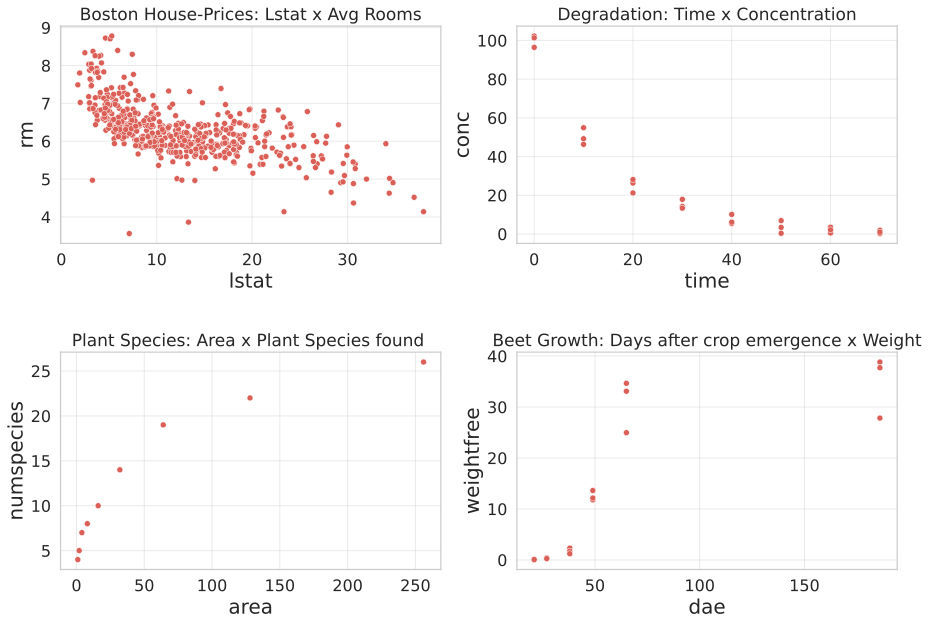

In [7]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))
ax = ax.ravel()
dfs_with_desc = [
    ("Boston House-Prices: Lstat x Avg Rooms", boston_df, "lstat", "rm"),
    ("Degradation: Time x Concentration", degradation_df, "time", "conc"),
    ("Plant Species: Area x Plant Species found ", species_df, "area", "numspecies"),
    ("Beet Growth: Days after crop emergence x Weight", beetgrowth_df, "dae", "weightfree"),
]
for i, (title, df, x, y) in enumerate(dfs_with_desc):
    sns.scatterplot(x=x, y=y, data=df, ax=ax[i])
    ax[i].set_title(title, fontsize=17)
plt.subplots_adjust(hspace=0.5)

# Curve Fitting

We'll mostly use the optimization procedures from Scipy's [`curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html). The main parameters we'll be using are:

- `f`: The function to call when optimizing, i.e. your model. It must have signature similar to `my_fn(x, a, b, c, d, ...)`, where `x` is your `x` and `a, b, c, d, ...` are other parameters. There are other valid signatures, but let's start with this simple one.
- `jac`: **Optional.** The function that returns the Jacobian of your function `f`. Sometimes it makes the optimization easier as the optimizer won't have to numerically approximate the gradient of your function.
- `xdata`: The `x` values
- `ydata`: The `y` values
- `p0`: **Optional.** The initial guess for the parameters
- `bounds`: **Optional.**  Constraints for the possible values of each parameter (useful to control general behavior of the optimization)
- `maxfev`: **Optional.**  Maximum number of function evaluations (basically, how many iterations).

The `curve_fit` returns the parameters from the optimization, which is what defines the model.



[1.91727273]


(Text(0.5, 0, 'X'),
 Text(0, 0.5, 'Y'),
 Text(0.5, 1.0, 'Simple fit'),
 <matplotlib.legend.Legend at 0x7f125adff748>)

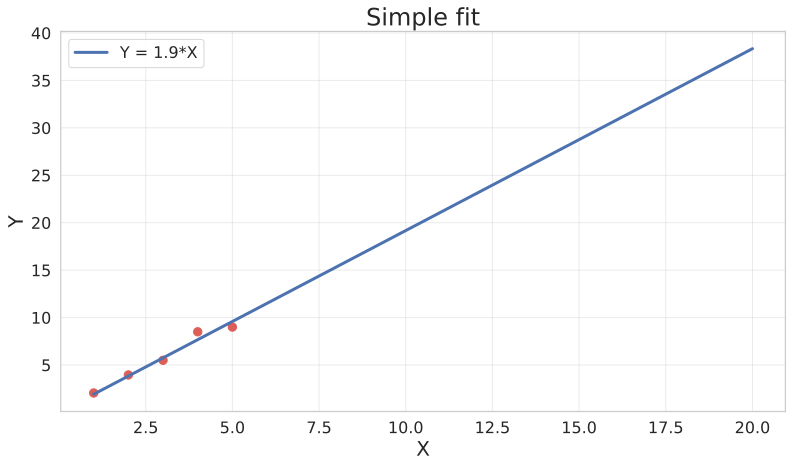

In [8]:
dummy_fn = lambda x, a: a*x
xfit = [1, 2, 3, 4, 5]
yfit  = [2.05, 3.95, 5.5, 8.5, 9]
res, pcov = curve_fit(
    f=dummy_fn,
    xdata=xfit,
    ydata=yfit,
    p0=[2] ## y = 2x is a good initial guess
)

# plot 
dummy_x = np.linspace(1, 20, 100)
plt.subplots(figsize=(13, 7))
plt.scatter(xfit, yfit, s=70)
plt.plot(dummy_x, dummy_fn(dummy_x, *res), color="b", label=f"Y = {round(res[0], 1)}*X")
print(res)
plt.xlabel("X"), plt.ylabel("Y"), plt.title("Simple fit"), plt.legend()

# Linear Models (warm-up)

## Simple Regression Line

In [9]:
simple_regression = smf.ols(formula="rm ~ lstat", data=boston_df).fit()
simple_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     rm   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     304.7
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           1.03e-53
Time:                        18:00:55   Log-Likelihood:                -419.27
No. Observations:                 506   AIC:                             842.5
Df Residuals:                     504   BIC:                             851.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0488      0.050    140.253      0.000       6.950       7.148
lstat         -0.0604      0.003    -17.455      0.000      -0.067      -0.054
==============================================================================
Omnibus:                       46.982   Durbin-Watson:                   1.240
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              217.735
Skew:                           0.211   Prob(JB):                     5.24e-48
Kurtosis:                       6.186   Cond. No.                         29.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:title={'center':'Lstat x Avg Rooms'}, xlabel='lstat', ylabel='rm'>

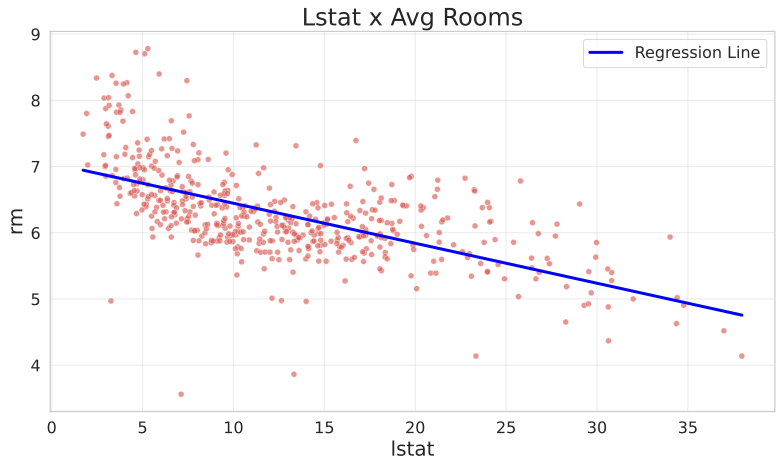

In [10]:
plt.subplots(figsize=(13, 7))
plt.title("Lstat x Avg Rooms")

xpreds_reg = pd.DataFrame(
    np.linspace(boston_df["lstat"].min(), boston_df["lstat"].max(), 500),
    columns=["lstat"],
).assign(prediction=lambda df: simple_regression.predict(df))
sns.scatterplot(x="lstat", y="rm", data=boston_df, alpha=0.65)
sns.lineplot(
    x="lstat", y="prediction", data=xpreds_reg, color="blue", label="Regression Line"
)

## Polynomials

You can use Scikit-learn's `PolynomialFeatures` to automatically generate polynomials interactions too.


https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

In [11]:
simple_polynomial = smf.ols(formula="rm ~ lstat + np.power(lstat, 2) + np.power(lstat, 3)", data=boston_df).fit()
simple_polynomial.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     rm   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     155.2
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           3.71e-71
Time:                        18:00:55   Log-Likelihood:                -372.89
No. Observations:                 506   AIC:                             753.8
Df Residuals:                     502   BIC:                             770.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              8.3238      0.135     61.670      0.000       8.059       8.589
lstat                 -0.3660      0.031    -11.834      0.000      -0.427      -0.305
np.power(lstat, 2)     0.0190      0.002      9.465      0.000       0.015       0.023
np.power(lstat, 3)    -0.0003   3.76e-05     -8.744      0.000      -0.000      -0.000
==============================================================================
Omnibus:                       60.585   Durbin-Watson:                   1.290
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              431.643
Skew:                          -0.158   Prob(JB):                     1.86e-94
Kurtosis:                       7.514   Cond. No.                     5.20e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

*Using a lot of polynomials with highly correlated features can lead to high condition number*

<AxesSubplot:title={'center':'Lstat x Avg Rooms'}, xlabel='lstat', ylabel='rm'>

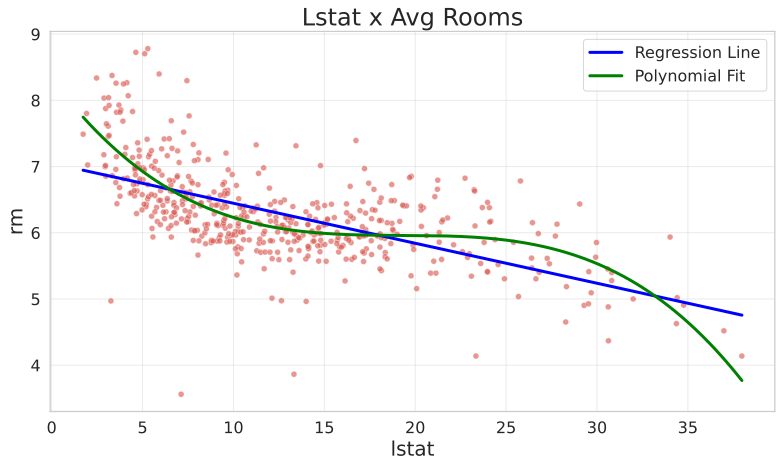

In [12]:
plt.subplots(figsize=(13, 7))
plt.title("Lstat x Avg Rooms")

xpreds_poly = xpreds_reg.assign(prediction=lambda df: simple_polynomial.predict(df))
sns.scatterplot(x="lstat", y="rm", data=boston_df, alpha=0.65)
sns.lineplot(
    x="lstat", y="prediction", data=xpreds_reg, color="blue", label="Regression Line"
)
sns.lineplot(
    x="lstat", y="prediction", data=xpreds_poly, color="green", label="Polynomial Fit"
)

# Concave/Convex Models



## Exponential Decay


**General parameterisation:**

$Y = a\cdot e^{k\cdot X}$

- $a$ is the value of $Y$ when $X = 0$
- $k$ is the relative increase or decrease of  $Y$ for a unit increase of $X$

In [13]:
def exponential_model(x, a, k):
    return a * np.exp(k * x)

We'll also provide the Jacobian for this model.

In [14]:
# Jacobian
a, k, x = symbols("a k x")
expr = a * exp(k * x)
diff(expr, a), diff(expr, k)

In [15]:
def exponential_model_jac(x, a, k):
    return np.array([np.exp(k * x), a * x * np.exp(k * x)]).T  # transform into column

The "problem" with Non Linear fits is that you usually have to provide a good starting point for the optimization!

Depending on your model, if the parameters are too sensitive (small numerical changes can drastically change the model) you might also need to manually decrease this sensitivity for numerical stability in the fitting procedure.

A fit without any starting point will result in this (very bad) model:

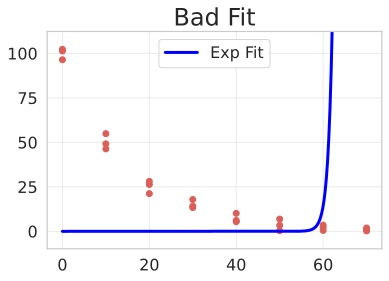

In [16]:
res, pcov = curve_fit(
    f=exponential_model,
    jac=exponential_model_jac, 
    xdata=degradation_df.time,
    ydata=degradation_df.conc,
)
xvals = np.linspace(degradation_df.time.min(), degradation_df.time.max(), 500)
plt.scatter(degradation_df.time, degradation_df.conc)
plt.plot(xvals, exponential_model(xvals, *res), c="blue", label="Exp Fit")
plt.title("Bad Fit"), plt.legend(), plt.ylim((degradation_df.conc.min() - 10, degradation_df.conc.max() + 10));

The easiest way to fix this is to set good starting parameters (`p0`). You could create a simple gridsearch to just get the general behavior of the model parameters and choose one as a starting point, use other fancy method or just put your best guess. 

**This is why it's important that you know exactly what you're trying to model and what the parameters represent!**

From looking at the data and our parameterisation, we can guess that:
- the value of $a$ should be closer to `100`
- the value of `k` should be negative, as the data shows an exponential decay behavior. 

Let's think about `k = -1` with `a=100`. In `x=40` the `y` value would be `100*exp(-40)`, which results in a very small value (when in fact it should result in something close to 10). So `k` should be much smaller, for example `-1e-3`.

Let's then try the fit with **p0=[100, -1e-3]** and see what happens:

(Text(0.5, 1.0, 'Good Fit - Exponential Decay'),
 (-9.8, 112.3))

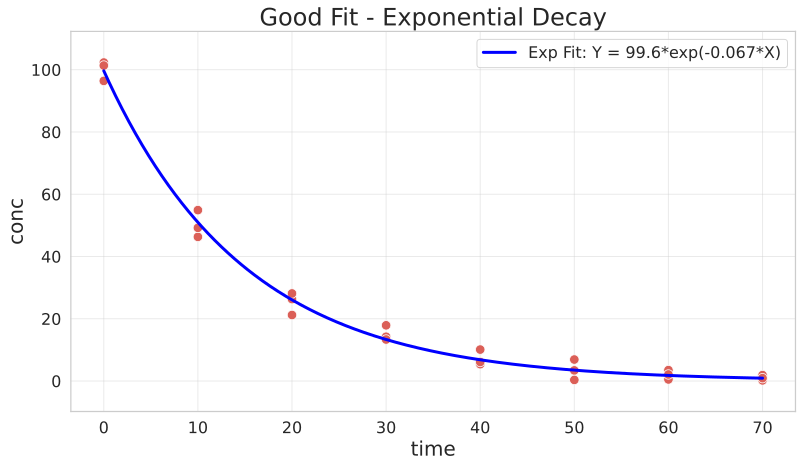

In [17]:
res, pcov = curve_fit(
    f=exponential_model,
    jac=exponential_model_jac,
    xdata=degradation_df.time,
    ydata=degradation_df.conc,
    p0=[100, -1e-3],
    bounds=(-np.inf, [np.inf, 0]),  # k cannot be greater than 0
)
plt.subplots(figsize=(13, 7))
xvals = np.linspace(degradation_df.time.min(), degradation_df.time.max(), 500)
sns.scatterplot(x="time", y="conc", data=degradation_df, s=90)
plt.plot(
    xvals,
    exponential_model(xvals, *res),
    c="blue",
    label=f"Exp Fit: Y = {round(res[0], 1)}*exp({round(res[1], 3)}*X)",
)
plt.title("Good Fit - Exponential Decay"), plt.legend(), plt.ylim(
    (degradation_df.conc.min() - 10, degradation_df.conc.max() + 10)
)

Much better!! =D

### Exponential decay with lower asymptote

**General parameterisation:**

$Y = b + (a - b)\cdot e^{k\cdot X}$

- $a$ is the value of $Y$ when $X = 0$
- $b$ is the lower asymptote where the decay will stabilize
- $k$ is the relative increase or decrease of  $Y$ for a unit increase of $X$

In [18]:
# Jacobian
a, b, k, x = symbols("a b k x")
expr = b + (a - b)*exp(k*x)
diff(expr, a), diff(expr, b), diff(expr, k)

(Text(0.5, 1.0, 'Exponential Decay with Lower Asymptote'),
 (5.199999999999999, 127.3))

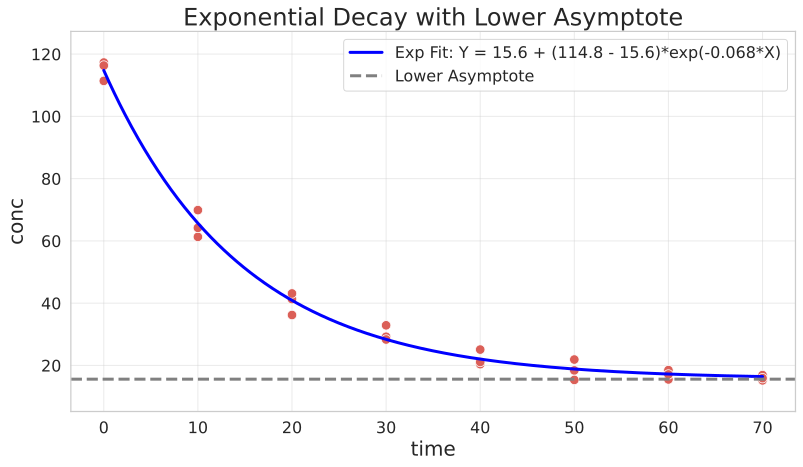

In [19]:
## functions
def exponential_decay_asymptote(x, a, b, k):
    return b + (a - b) * np.exp(k * x)


def exponential_decay_asymptote_jac(x, a, b, k):
    return np.array([np.exp(k * x), 1 - np.exp(k * x), x * (a - b) * np.exp(k * x)]).T


offset = 15  # manual concentration offset for illustration purpose
## fit
res, pcov = curve_fit(
    f=exponential_decay_asymptote,
    jac=exponential_decay_asymptote_jac,
    xdata=degradation_df.time,
    ydata=degradation_df.conc + offset,
    p0=[100, 10, -1e-3],  # putting 10 as a starting point for the lower asymptote
    bounds=(-np.inf, [np.inf, np.inf, 0]),  # k cannot be greater than 0
)
a, b, k = res
## plot
plt.subplots(figsize=(13, 7))
xvals = np.linspace(degradation_df.time.min(), degradation_df.time.max(), 500)
sns.scatterplot(
    x="time",
    y="conc",
    data=degradation_df.assign(conc=lambda df: df.conc + offset),
    s=90,
)
plt.plot(
    xvals,
    exponential_decay_asymptote(xvals, *res),
    c="blue",
    label=f"Exp Fit: Y = {round(b, 1)} + ({round(a, 1)} - {round(b, 1)})*exp({round(k, 3)}*X)",
)
plt.axhline(b, c="gray", linestyle="--", label="Lower Asymptote")
plt.title("Exponential Decay with Lower Asymptote"), plt.legend(), plt.ylim(
    (degradation_df.conc.min() - 10 + offset, degradation_df.conc.max() + 10 + offset)
)

## Asymptotic Model (Negative Exponential)

Basically the opposite of the exponential decay model. It can be used to describe phenomena where $Y$ has a limited growth as $X$ goes to infinity. 
> For example, if $Y$ is the length of a fish and $X$ represents its age, we expect a growth (increase in the fish length) as it ages, but it won't constantly increase in length, it will probably stabilize on maximum obtainable length. This fish example was based on the von Bertalanffy law. Also, we don't expect the fish to have $0$ length when it's born, so the common parameterisation of this type of model also has a parameter to control this.

**General parameterisation:**



$Y = b - (b - a)\cdot e^{-k\cdot X}$

- $a$ is the value of $Y$ when $X = 0$
- $b$ is the upper asymptote where the growth will stabilize (maximum attainable value for $Y$)
- $k$ is the relative increase or decrease of  $Y$ for a unit increase of $X$


In [20]:
growth_data_df = degradation_df.assign(length=lambda df: (1 - df.conc) + 120)[["time", "length"]] # re-using the degradation data but swapping the direction|
growth_data_df.head()

,time,length
0,0,24.60
1,10,74.70
2,20,99.80
3,30,103.11
4,40,110.90


In [21]:
# Jacobian
a, b, k, x = symbols("a b k x")
expr = b - (b - a)*exp(-k*x)
diff(expr, a), diff(expr, b), diff(expr, k)

[2.12253737e+01 1.20409467e+02 6.82983195e-02]


(Text(0.5, 1.0, 'Asymptotic Model'),
 (8.700000000000003, 130.8))

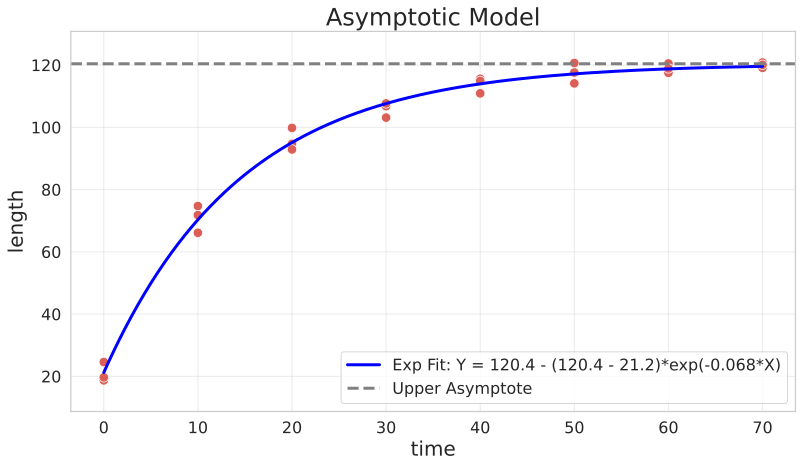

In [22]:
## functions
def negative_exponential_asymptote(x, a, b, k):
    return b - (b - a) * np.exp(-k * x)


def negative_exponential_asymptote_jac(x, a, b, k):
    return np.array(
        [np.exp(-k * x), 1 - np.exp(-k * x), -x * (a - b) * np.exp(-k * x)]
    ).T


## fit
res, pcov = curve_fit(
    f=negative_exponential_asymptote,
    jac=negative_exponential_asymptote_jac,
    xdata=growth_data_df.time,
    ydata=growth_data_df.length,
    p0=[
        0,
        200,
        1e-3,
    ],  # Y can start at 0 when X=0, the asymptote guess is 200 and the rate guess is 1e-3
    bounds=(0, [np.inf, np.inf, 1]),  # adding constraints
)
a, b, k = res
print(res)

## plot
plt.subplots(figsize=(13, 7))
xvals = np.linspace(growth_data_df.time.min(), growth_data_df.time.max(), 500)
sns.scatterplot(x="time", y="length", data=growth_data_df, s=90)
plt.plot(
    xvals,
    negative_exponential_asymptote(xvals, *res),
    c="blue",
    label=f"Exp Fit: Y = {round(b, 1)} - ({round(b, 1)} - {round(a, 1)})*exp(-{round(k, 3)}*X)",
)
plt.axhline(b, c="gray", linestyle="--", label="Upper Asymptote")
plt.title("Asymptotic Model"), plt.legend(), plt.ylim(
    (growth_data_df.length.min() - 10, growth_data_df.length.max() + 10)
)

## Asymptotic Model starting from 0

Sometimes your model needs to start from 0 (i.e. $a = 0$ from the previous equation). This results in a simpler parameterisation, albeit with the same behavior.

**General parameterisation:**



$Y = b\cdot (1 - e^{-k\cdot X})$

- $b$ is the upper asymptote where the growth will stabilize (maximum attainable value for $Y$)
- $k$ is the relative increase or decrease of  $Y$ for a unit increase of $X$


In [23]:
# Jacobian
b, k, x = symbols("b k x")
expr = b*(1 - exp(-k*x))
diff(expr, b), diff(expr, k)

[1.0027948e+02 6.9302165e-02]


(Text(0.5, 1.0, 'Asymptotic Model (starting from 0)'),
 (-11.299999999999997, 110.80000000000001))

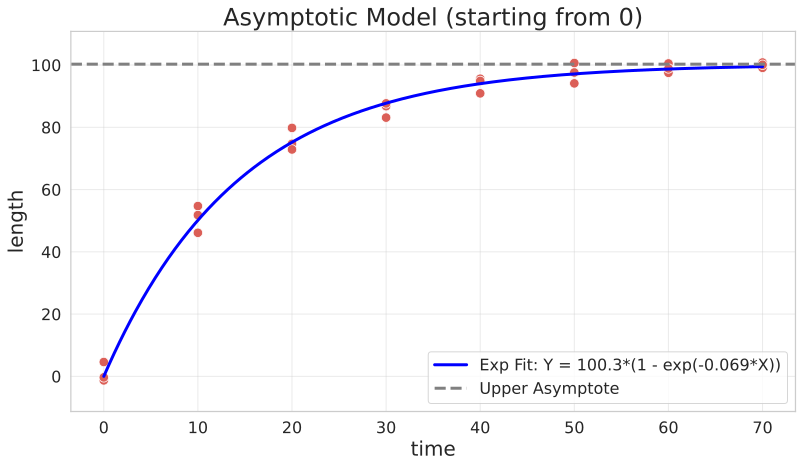

In [24]:
## functions
def negative_exponential(x, b, k):
    return b * (1 - np.exp(-k * x))


def negative_exponential_jac(x, b, k):
    return np.array([1 - np.exp(-k * x), b * x * np.exp(-k * x)]).T


offset = -20
## fit
res, pcov = curve_fit(
    f=negative_exponential,
    jac=negative_exponential_jac,
    xdata=growth_data_df.time,
    ydata=growth_data_df.length + offset,
    p0=[200, 1e-3],  # the asymptote guess is 200 and the rate guess is 1e-3
    bounds=(0, [np.inf, 3]),  # adding constraints
)
b, k = res
print(res)

## plot
plt.subplots(figsize=(13, 7))
xvals = np.linspace(growth_data_df.time.min(), growth_data_df.time.max(), 500)
sns.scatterplot(
    x="time",
    y="length",
    data=growth_data_df.assign(length=lambda df: df.length + offset),
    s=90,
)
plt.plot(
    xvals,
    negative_exponential(xvals, *res),
    c="blue",
    label=f"Exp Fit: Y = {round(b, 1)}*(1 - exp(-{round(k, 3)}*X))",
)
plt.axhline(b, c="gray", linestyle="--", label="Upper Asymptote")
plt.title("Asymptotic Model (starting from 0)"), plt.legend(), plt.ylim(
    (
        growth_data_df.length.min() - 10 + offset,
        growth_data_df.length.max() + 10 + offset,
    )
)

## Power Regression


**General parameterisation:**



$Y = a\cdot X^{b}$

- $a$ is the value of $Y$ when $X = 0$
- $b$ is the power (controls how $Y$ increases relative to $X$

---

The Power Regression is equivalent to an exponential curve but with the logarithm of $X$:

$$aX^b = a\cdot e^{log(X^b)} = a\cdot e^{b\cdot log(X)}$$


In [25]:
# Jacobian
a, b, x = symbols("a b x")
expr = a*(x**b)
diff(expr, a), diff(expr, b)

[4.3483245  0.32977411]


(Text(0.5, 1.0, 'Power Regression'),
 (-1.0, 31.0))

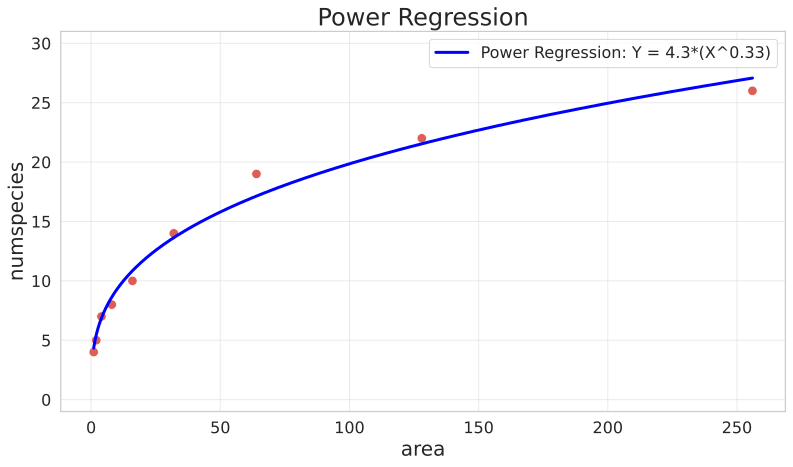

In [26]:
## functions
def power_regr(x, a, b):
    return a * np.power(x, b)


def power_regr_jac(x, a, b):
    return np.array([np.power(x, b), a * np.power(x, b) * np.log(x)]).T


## fit
res, pcov = curve_fit(
    f=power_regr,
    jac=power_regr_jac,
    xdata=species_df.area,
    ydata=species_df.numspecies,
    p0=[200, 2],  # it starts at 0, power guess is 2 (quadratic behavior)
)
a, b = res
print(res)

## plot
plt.subplots(figsize=(13, 7))
xvals = np.linspace(species_df.area.min(), species_df.area.max(), 500)
sns.scatterplot(x="area", y="numspecies", data=species_df, s=90)
plt.plot(
    xvals,
    power_regr(xvals, *res),
    c="blue",
    label=f"Power Regression: Y = {round(a, 1)}*(X^{round(b, 3)})",
)
# plt.axhline(b, c="gray", linestyle="--", label="Upper Asymptote")
plt.title("Power Regression"), plt.legend(), plt.ylim(
    (species_df.numspecies.min() - 5, species_df.numspecies.max() + 5)
)

A useful property of the Power parameter is that you can bound it in the fit depending on the growth behavior you're trying to model.

- $0 < b < 1$: Convex shape, $Y$ increases as $X$ increases.
- $b < 0$: Concave shape, $Y$ decreases as $X$ increases.
- $b > 1$: Concave shape, $Y$ increases as $X$ increases.

Here are some examples:



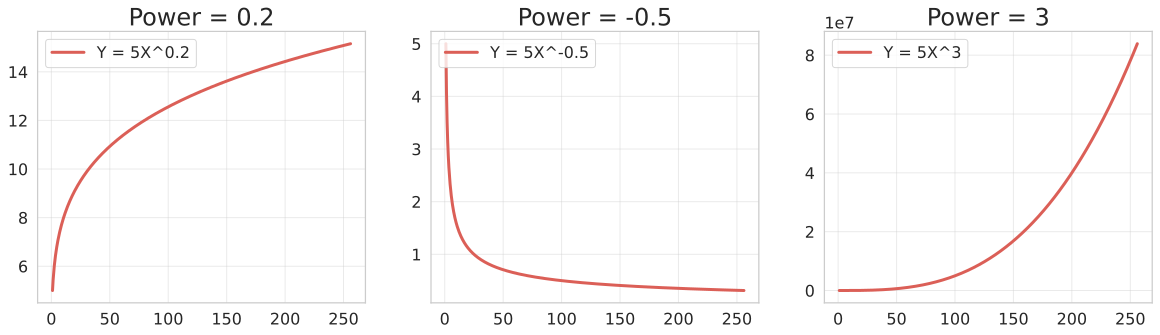

In [27]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 5))
ax = ax.ravel()
a = 5 # let's start from 5 at X = 0
for i, b in enumerate([0.2, -0.5, 3]):
    ax[i].plot(xvals, power_regr(xvals, a=a, b=b), label=f"Y = {a}X^{round(b, 1)}")
    ax[i].legend(loc=2)
    ax[i].set_title(f"Power = {b}")

# Sygmoidal curves

## Logistic Curve

The logistic curve should be familiar to any data scientist. It's derived from the cumulative logistic distribution function and is symmetric around a inflection point.


**General parameterisation:**


$$Y = a + \frac{c - a}{1 + e^{b(X - d)}}$$

- $c$ is the upper asymptote
- $a$ is the lower asymptote
- $d$ controls the location of the inflection point
- $b$ the slope around the inflection point, and we can use it to control the 'growth' behavior. If $b < 0$, then $Y$ increases as $X$ increases and if $b > 0$ then $Y$ decreases as $X$ increases.
---

This parameterisation above is general, but depending on what you're trying to fit it can be reduced. For example, if we se $a = 0$ we have a simpler equation. We could also force $c = 1$ furthermore, making the equation even simpler. It all depends on the constraints of your problem.





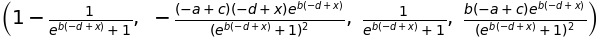

In [28]:
# Jacobian
a, b, c, d, x = symbols("a b c d x")
expr = a + (c - a)/(1 + exp(b*(x - d)))
diff(expr, a), diff(expr, b), diff(expr, c), diff(expr, d)

This is a more complex jacobian. You don't always need to input the jacobian because `curve_fit` will numerically approximate it if you want, so feel free to skip this time :D

I'm just gonna create the function for reference later.

[ 9.63816824e-11 -2.01171276e-01  3.43513413e+01  5.19052926e+01]


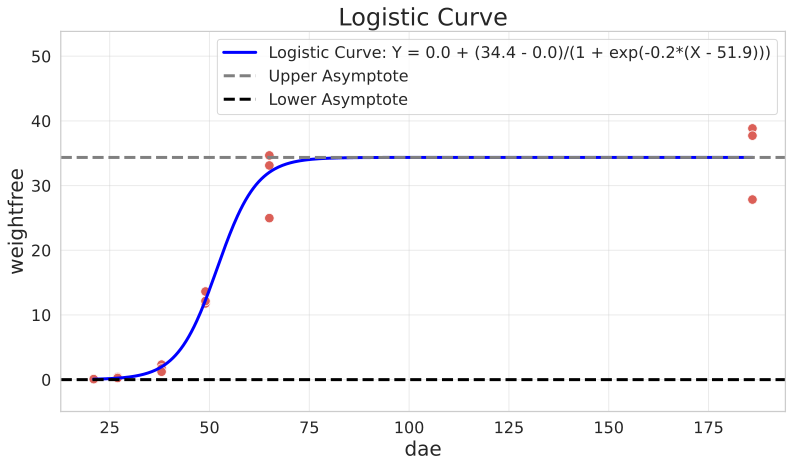

In [29]:
def logistic_curve(x, a, b, c, d):
    return a + (c - a) / (1 + np.exp(b * (x - d)))


def logistic_curve_jac(x, a, b, c, d):
    return np.array(
        [
            1 - (1 / (np.exp(b * (-d + x)) + 1)),
            ((-a + c) * (-d + x) * np.exp(b * (-d + x)))
            / (np.exp(b * (-d + x)) + 1) ** 2,
            (1) / (np.exp(b * (-d + x)) + 1),
            (b * (-a + c) * np.exp(b * (-d + x))) / (np.exp(b * (-d + x)) + 1) ** 2,
        ]
    ).T


## fit
res, pcov = curve_fit(
    f=logistic_curve,
    jac=logistic_curve_jac,
    xdata=beetgrowth_df.dae,
    ydata=beetgrowth_df.weightfree,
    p0=[
        0,
        -0.1,
        50,
        30,
    ],  # lower asymptote guess is 0, b is negative (Y increases with X), upper asymptote guess is 50 and inflection point guess is at 30 dae
    bounds=([0, -np.inf, -np.inf, -np.inf], [0.1, 0, np.inf, np.inf]),
    maxfev=3000,
)
a, b, c, d = res
print(res)
res_log = res # saving the logistic curve fit

## plot
plt.subplots(figsize=(13, 7))
xvals = np.linspace(beetgrowth_df.dae.min(), beetgrowth_df.dae.max(), 500)
sns.scatterplot(x="dae", y="weightfree", data=beetgrowth_df, s=90)
plt.plot(
    xvals,
    logistic_curve(xvals, *res),
    c="blue",
        label=f"Logistic Curve: Y = {round(a, 1)} + ({round(c, 1)} - {round(a, 1)})/(1 + exp({round(b, 1)}*(X - {round(d, 1)})))",
)
plt.axhline(c, c="gray", linestyle="--", label="Upper Asymptote")
plt.axhline(a, c="black", linestyle="--", label="Lower Asymptote")

plt.title("Logistic Curve"), plt.legend(loc=1), plt.ylim(
    (beetgrowth_df.weightfree.min() - 5, beetgrowth_df.weightfree.max() + 15)
);

## Gompertz Function

Or more specifically, the [Gompertz Curve](https://en.wikipedia.org/wiki/Gompertz_function). Not always the problem we're modelling is symmetric, and the Gompertz function can model different "growth speeds" around the inflection point. I suggest you take a look at the Wikipedia page for this function, here are some examples of where it can be used:

- Mobile phone uptake, where costs were initially high (so uptake was slow), followed by a period of rapid growth, followed by a slowing of uptake as saturation was reached
- Population in a confined space, as birth rates first increase and then slow as resource limits are reached
- Modelling of growth of tumors
- Modelling market impact in finance and aggregated subnational loans dynamic.



**General parameterisation:**


$$Y = a + (c - a)\cdot e^{-e^{b(X - d)}}$$

The parameters have similar interpretation as in the Logistic Curve.

- $c$ is the upper asymptote
- $a$ is the lower asymptote
- $d$ controls the location of the inflection point
- $b$ the slope around the inflection point, and we can use it to control the 'growth' behavior. If $b < 0$, then $Y$ increases as $X$ increases and if $b > 0$ then $Y$ decreases as $X$ increases.





In [30]:
# Jacobian
a, b, c, d, x = symbols("a b c d x")
expr = a + (c - a)*exp(-exp(b*(x - d)))
diff(expr, a), diff(expr, b), diff(expr, c), diff(expr, d)

These are getting crazier over time..

[ 0.1        -0.12185379 34.81878031 48.55573041]


(Text(0.5, 1.0, 'Gompertz Curve'),
 (-4.9337453, 53.83299116))

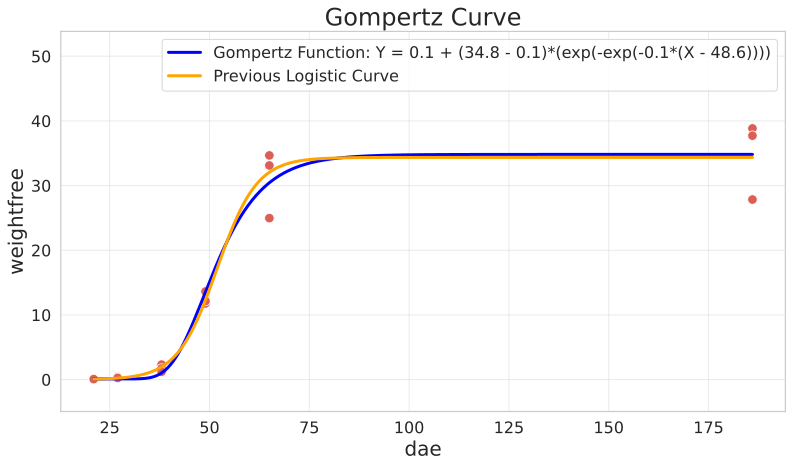

In [31]:
def gompertz_function(x, a, b, c, d):
    return a + (c - a) * np.exp(-np.exp(b * (x - d)))


def gompertz_function_jac(x, a, b, c, d):
    return np.array(
        [
            1 - np.exp(-np.exp(b * (-d + x))),
            -(-a + c) * (-d + x) * np.exp(b * (-d + x)) * np.exp(-np.exp(b * (-d + x))),
            np.exp(-np.exp(b * (-d + x))),
            b * (-a + c) * np.exp(b * (-d + x) * np.exp(-np.exp(b * (-d + x)))),
        ]
    ).T


## fit
res, pcov = curve_fit(
    f=gompertz_function,
    jac=gompertz_function_jac,
    xdata=beetgrowth_df.dae,
    ydata=beetgrowth_df.weightfree,
    p0=[
        0,
        -0.1,
        50,
        30,
    ],  # lower asymptote guess is 0, b is negative (Y increases with X), upper asymptote guess is 50 and inflection point guess is at 30 dae
    bounds=([0, -np.inf, -np.inf, -np.inf], [0.1, 0, np.inf, np.inf]),
    maxfev=3000,
)
a, b, c, d = res
print(res)

## plot
plt.subplots(figsize=(13, 7))
xvals = np.linspace(beetgrowth_df.dae.min(), beetgrowth_df.dae.max(), 500)
sns.scatterplot(x="dae", y="weightfree", data=beetgrowth_df, s=90)
plt.plot(
    xvals,
    gompertz_function(xvals, *res),
    c="blue",
    label=f"Gompertz Function: Y = {round(a, 1)} + ({round(c, 1)} - {round(a, 1)})*(exp(-exp({round(b, 1)}*(X - {round(d, 1)}))))",
)
plt.plot(
    xvals,
    logistic_curve(xvals, *res_log),
    c="orange",
    label=f"Previous Logistic Curve",
)
# plt.axhline(c, c="gray", linestyle="--", label="Upper Asymptote")
# plt.axhline(a, c="black", linestyle="--", label="Lower Asymptote")

plt.title("Gompertz Curve"), plt.legend(loc=1), plt.ylim(
    (beetgrowth_df.weightfree.min() - 5, beetgrowth_df.weightfree.max() + 15)
)

The Gompertz Curve has an alternative parameterisation that inverts the growth pattern from the general one:

$$Y = a + (c - a)\cdot \left[1 - e^{-e^{-b(X - d)}}\right]$$

I won't fit anything to it as it's quite similar to the previous one.

Here is an example to better visualize the difference between them. The parameters here are:
`a=2, b=-0.5, c=10, d=7`

(<matplotlib.legend.Legend at 0x7f12515c5c18>,
 Text(0.5, 1.0, 'Different Sygmoidal functions'))

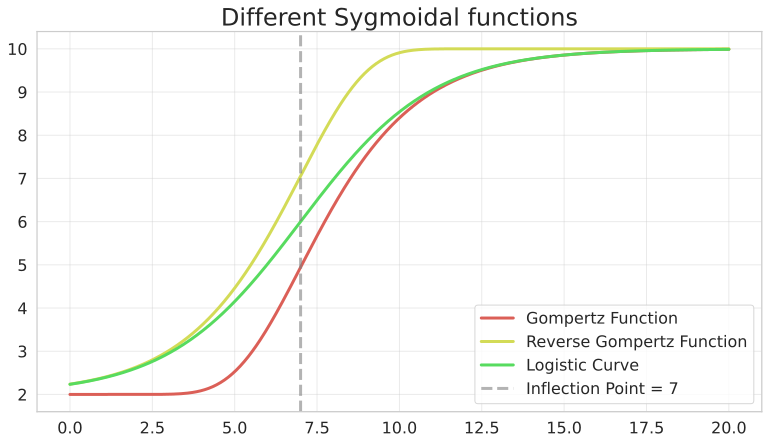

In [32]:
def reverse_gompertz_function(x, a, b, c, d):
    return a + (c - a) * (1 - np.exp(-np.exp(-b * (x - d))))


a, b, c, d = 2, -0.5, 10, 7
params = (a, b, c, d)
xvals = np.linspace(0, 20, 500)
functions_to_plot = [
    ("Gompertz Function", gompertz_function),
    ("Reverse Gompertz Function", reverse_gompertz_function),
    ("Logistic Curve", logistic_curve),
]
plt.subplots(figsize=(13, 7))
for i, (label, model) in enumerate(functions_to_plot):
    plt.plot(xvals, model(xvals, *params), label=label, c=sns.color_palette()[i])
plt.axvline(d, linestyle="--", label=f"Inflection Point = {d}", c="gray", alpha=0.6)
plt.legend(), plt.title("Different Sygmoidal functions")